# Notes
Added terrain options

Switched order of Nx and Ny in some of the code. Use: Ny, Nx in this order. Ny = #rows, Nx = # columns

In [123]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline
import numpy as np
from datetime import datetime

In [124]:
   class Hexgrid():
    def __init__(self, Nx, Ny, repositeAngle = np.deg2rad(20), dx=1, terrain=True):
        self.Nx = Nx
        self.Ny = Ny
#         self.height = np.zeros((self.Nx,self.Ny))
        self.height = np.ones((self.Ny,self.Nx)) * np.inf # Had to put in a border
        self.height[1:self.Ny-1,1:self.Nx-1] = 0
        
        self.dx = dx
        self.repositeAngle = repositeAngle
        self.X = np.zeros((Nx, Ny, 2)) # X[:,:,0] = X coords, X[:,:,1] = Y coords
        for j in range(Ny):
            self.X[:,j,0] = j*self.dx/2 + np.arange(Nx) * dx    
            self.X[:,j,1] = np.ones(Nx) * self.dx*np.sqrt(3)/2 * j
        
        if(terrain == True):
            self.seaBed = np.abs(self.X[:,:,1]-20) + self.X[:,1,1]
        else:
            self.seaBed = np.zeros((self.Ny,self.Nx))
        self.totalheight = self.height + self.seaBed
        
        # Calculate the differences between the sea bed heights for all cell - neighbor pairs
        self.seaBedDiff= np.zeros((self.Ny-2,self.Nx-2,6))
        self.seaBedDiff[:,:,0] = self.seaBed[1:self.Ny-1,1:self.Nx-1] - self.seaBed[0:self.Ny-2, 1:self.Nx-1]
        self.seaBedDiff[:,:,1] = self.seaBed[1:self.Ny-1,1:self.Nx-1] - self.seaBed[0:self.Ny-2, 2:self.Nx  ]
        self.seaBedDiff[:,:,2] = self.seaBed[1:self.Ny-1,1:self.Nx-1] - self.seaBed[1:self.Ny-1, 2:self.Nx  ]
        self.seaBedDiff[:,:,3] = self.seaBed[1:self.Ny-1,1:self.Nx-1] - self.seaBed[2:self.Ny  , 1:self.Nx-1]
        self.seaBedDiff[:,:,4] = self.seaBed[1:self.Ny-1,1:self.Nx-1] - self.seaBed[2:self.Ny  , 0:self.Nx-2]
        self.seaBedDiff[:,:,5] = self.seaBed[1:self.Ny-1,1:self.Nx-1] - self.seaBed[1:self.Ny-1, 0:self.Nx-2]
        
            
    def update_heightNew(self):        
        # First, make copy of current height array
        old_height = self.height.copy()
        
        

        
        
        interiorH = old_height[1:self.Ny-1,1:self.Nx-1]

        # Calculate height differences of all neighbors
        NWdiff =  interiorH - old_height[0:self.Ny-2, 1:self.Nx-1] + self.seaBedDiff[:,:,0] 
        NEdiff =  interiorH - old_height[0:self.Ny-2, 2:self.Nx  ] + self.seaBedDiff[:,:,1]
        Ediff  =  interiorH - old_height[1:self.Ny-1, 2:self.Nx  ] + self.seaBedDiff[:,:,2]
        SEdiff =  interiorH - old_height[2:self.Ny  , 1:self.Nx-1] + self.seaBedDiff[:,:,3]
        SWdiff =  interiorH - old_height[2:self.Ny  , 0:self.Nx-2] + self.seaBedDiff[:,:,4]
        Wdiff  =  interiorH - old_height[1:self.Ny-1, 0:self.Nx-2] + self.seaBedDiff[:,:,5]
        

        # Find angles
        NWangle = np.arctan(NWdiff/self.dx) # Angle between "my cell" and the one in the north west
        NEangle = np.arctan(NEdiff/self.dx)
        Eangle  = np.arctan(Ediff/self.dx)
        SEangle = np.arctan(SEdiff/self.dx)
        SWangle = np.arctan(SWdiff/self.dx)
        Wangle  = np.arctan(Wdiff/self.dx)
        
        
        
        # (Checks if cell (i,j) has angle > reposite angle and that it has mass > 0. For all directions.)      
        # Find cells (i,j) for which to transfer mass in the direction given
        NWindices = np.where(np.logical_and(np.greater(NWangle,self.repositeAngle),np.greater(interiorH,0))) # Gives indices (i,j) where the current angle > reposite angle and where height is > 0
        NEindices = np.where(np.logical_and(np.greater(NEangle,self.repositeAngle),np.greater(interiorH,0)))
        Eindices  = np.where(np.logical_and(np.greater(Eangle,self.repositeAngle),np.greater(interiorH,0)))
        SEindices = np.where(np.logical_and(np.greater(SEangle,self.repositeAngle),np.greater(interiorH,0)))
        SWindices = np.where(np.logical_and(np.greater(SWangle,self.repositeAngle),np.greater(interiorH,0)))
        Windices  = np.where(np.logical_and(np.greater(Wangle,self.repositeAngle),np.greater(interiorH,0)))
        
        # Count up the number of cells (i,j) will be transfering mass to. If none, set (i,j) to infinity so that division works.
        NoOfTrans = np.zeros((self.Ny-2,self.Nx-2))
        NoOfTrans[NWindices] += 1
        NoOfTrans[NEindices] += 1
        NoOfTrans[Eindices]  += 1
        NoOfTrans[SEindices] += 1
        NoOfTrans[SWindices] += 1
        NoOfTrans[Windices]  += 1
        NoOfTrans[np.where(NoOfTrans == 0)] = np.inf
        
        # Calculate fractions of mass to be transfered
        NWfrac = (0.5 * (NWdiff[NWindices] - self.dx * np.tan(self.repositeAngle))/interiorH [NWindices])
        NEfrac = (0.5 * (NEdiff[NEindices] - self.dx * np.tan(self.repositeAngle))/interiorH [NEindices])
        Efrac  = (0.5 * (Ediff [Eindices ]  - self.dx * np.tan(self.repositeAngle))/interiorH[Eindices ])
        SEfrac = (0.5 * (SEdiff[SEindices] - self.dx * np.tan(self.repositeAngle))/interiorH [SEindices])
        SWfrac = (0.5 * (SWdiff[SWindices] - self.dx * np.tan(self.repositeAngle))/interiorH [SWindices])
        Wfrac  = (0.5 * (Wdiff [Windices ]  - self.dx * np.tan(self.repositeAngle))/interiorH[Windices ])
        
#         print(" Fraction of mass to be transfered from index (i,j) to index (i,j-1)")
#         print(NWfrac)
        
        NWdeltaS = interiorH[NWindices] * NWfrac/NoOfTrans[NWindices] # Mass to be transfered from index [i,j] to index [i-1,j]
        NEdeltaS = interiorH[NEindices] * NEfrac/NoOfTrans[NEindices]
        EdeltaS  = interiorH[Eindices ] * Efrac /NoOfTrans[Eindices] 
        SEdeltaS = interiorH[SEindices] * SEfrac/NoOfTrans[SEindices]
        SWdeltaS = interiorH[SWindices] * SWfrac/NoOfTrans[SWindices]
        WdeltaS  = interiorH[Windices ] * Wfrac /NoOfTrans[Windices] 
        
        
        # Lag en endringsmatrise delta S som kan legges til self.height
        deltaS = np.zeros((self.Ny-2,self.Nx-2))
        
        # Trekk fra massen som skal sendes ut fra celler
        deltaS[NWindices] -= NWdeltaS
        deltaS[NEindices] -= NEdeltaS
        deltaS[Eindices]  -= EdeltaS
        deltaS[SEindices] -= SEdeltaS
        deltaS[SWindices] -= SWdeltaS
        deltaS[Windices]  -= WdeltaS
        
        
        # Legg til massen som skal tas imot
        deltaS[[NWindices[0]-1,NWindices[1]]]   += NWdeltaS
        deltaS[[NEindices[0]-1,NEindices[1]+1]] += NEdeltaS
        deltaS[[Eindices[0],Eindices[1]+1]]     += EdeltaS
        deltaS[[SEindices[0]+1,SEindices[1]]]   += SEdeltaS
        deltaS[[SWindices[0]+1,SWindices[1]-1]] += SWdeltaS
        deltaS[[Windices[0],Windices[1]-1]]     += WdeltaS
        
#         print("deltaS: ")
#         print(deltaS)
        
        self.height[1:self.Ny-1,1:self.Nx-1] += deltaS
        self.totalheight = self.seaBed + self.height # Update total height
#         print("New height")
#         print(self.height)
        
        
        
    def update_height(self):
        # Starting with an approach based on double for loop
        # TODO: Optimize this to using array expressions where possible
        
        # First, make copy of current height array
        old_height = self.height.copy()
        
        for i in range(self.Nx):
            for j in range(self.Ny):
                # Loop over neighbours
                frac = []
                transferToIndex = []
                for k, l in self.get_neighbour_indices(i, j):
                    # Calculate angle
                    heightDiff = old_height[i,j] - old_height[k, l] # Find height diff
                    angle = np.arctan(heightDiff/self.dx)
                    if (angle > self.repositeAngle) and (old_height[i,j] > 0):
                        frac.append(0.5 * (heightDiff - self.dx * np.tan(self.repositeAngle))/old_height[i,j])
                        transferToIndex.append((k, l))

                for n, (k, l) in enumerate(transferToIndex):
                    deltaS = old_height[i,j]*(frac[n]/frac.__len__())
                    self.height[i,j] -= deltaS
                    self.height[k,l] += deltaS



# A simple test case Using global array operations

Time used to calculate  1000  timesteps:  0:00:00.431845
Sum of mass in all cells:  5000.0


Text(0.5,1,'Terrain(x,y)')

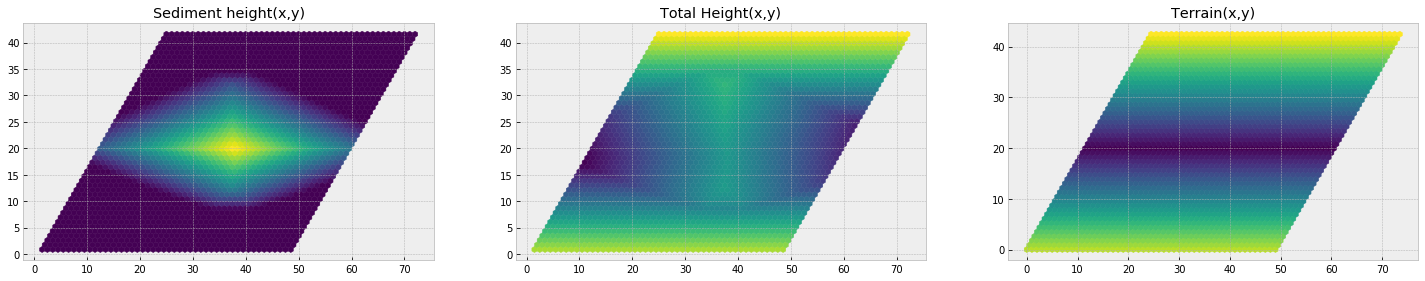

In [132]:
startTime = datetime.now()

grid = Hexgrid(50,50)
# grid.height[1,1] = 500
grid.height[25, 25] = 5000
# grid.height[47,47] = 500
# print(grid.height)
for i in range(1000):
    grid.update_heightNew()

print ("Time used to calculate " , i+1 , " timesteps: ", datetime.now() - startTime)
print("Sum of mass in all cells: ", np.sum(grid.height[1:grid.Nx-1,1:grid.Ny-1]))


fig = plt.figure(figsize = (25,25))
ax = fig.add_subplot(131, aspect = 'equal')
ax.scatter(grid.X[:,:,0].flatten(), grid.X[:,:,1].flatten(), marker = 'h', c = grid.height.flatten())
ax.set_title('Sediment height(x,y)')


#fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(132, aspect = 'equal')
ax.scatter(grid.X[:,:,0].flatten(), grid.X[:,:,1].flatten(), marker = 'h', c = grid.totalheight.flatten())
ax.set_title('Total Height(x,y)')

# fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(133, aspect = 'equal')
ax.scatter(grid.X[:,:,0].flatten(), grid.X[:,:,1].flatten(), marker = 'h', c = grid.seaBed.flatten())
ax.set_title('Terrain(x,y)')

# Same example but with terrain disabled

Time used to calculate  1000  timesteps:  0:00:00.438825
Sum of mass in all cells:  5000.0


Text(0.5,1,'Terrain(x,y)')

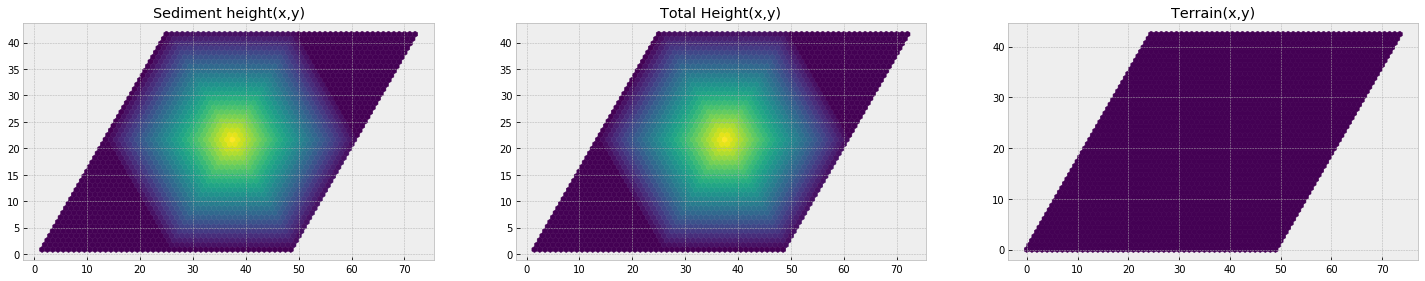

In [131]:
startTime = datetime.now()

grid = Hexgrid(50,50, terrain=0)
# grid.height[1,1] = 500
grid.height[25, 25] = 5000
# grid.height[47,47] = 500
# print(grid.height)
for i in range(1000):
    grid.update_heightNew()

print ("Time used to calculate " , i+1 , " timesteps: ", datetime.now() - startTime)
print("Sum of mass in all cells: ", np.sum(grid.height[1:grid.Nx-1,1:grid.Ny-1]))


fig = plt.figure(figsize = (25,25))
ax = fig.add_subplot(131, aspect = 'equal')
ax.scatter(grid.X[:,:,0].flatten(), grid.X[:,:,1].flatten(), marker = 'h', c = grid.height.flatten())
ax.set_title('Sediment height(x,y)')


#fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(132, aspect = 'equal')
ax.scatter(grid.X[:,:,0].flatten(), grid.X[:,:,1].flatten(), marker = 'h', c = grid.totalheight.flatten())
ax.set_title('Total Height(x,y)')

# fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(133, aspect = 'equal')
ax.scatter(grid.X[:,:,0].flatten(), grid.X[:,:,1].flatten(), marker = 'h', c = grid.seaBed.flatten())
ax.set_title('Terrain(x,y)')